In [1]:
# Import the libraries

import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import wave
import soundfile as sf
import librosa as lb

import dask

from IPython.display import Audio

import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import tensorflow.keras as keras

from IPython.display import Audio
from IPython.utils import io
from synthesizer.inference import Synthesizer
from encoder import inference as encoder
from vocoder import inference as vocoder
from pathlib import Path

In [2]:
# Establish the main path

path1 = '/Users/arnaldofolder/Documents/Apziva/Sixth_Project/data/TRAIN'

In [3]:
# Directories to loop through

directories = next(os.walk(path1))[1]

new_path = []

for d in directories:
    d_path = path1 + '/' + d
    new_path.append(d_path)

In [4]:
# Save all the directories in a list

all_directories = []

for i,j in enumerate(new_path):
    folder_directories = next(os.walk(new_path[i]))[1]
    
    for d in folder_directories:
        current_directory = new_path[i] + '/' + d
        all_directories.append(current_directory)
    


In [5]:
# Create a function to have the different audio samples and run the voice-cloner function

def preprocessor(paths):
    
    sample_audios = []
    
    for path in paths:
        audio_files = glob.glob(path + '/*.WAV')
        audio_file, freq = lb.load(audio_files[0])
        freq = np.array(freq)
        
        for i in range(1, len(audio_files)):
            audio, freqs = lb.load(audio_files[i])
            audio_file = np.concatenate((audio_file, audio), axis = None)
            freqs = np.concatenate((freq, freqs), axis = None)
            
        sample_audios.append(audio_file)
        
    return sample_audios

In [6]:
# Apply the function to all the directories

sample_audios = preprocessor(paths = all_directories)

In [7]:
# Display a sample audio

Audio(data = sample_audios[2], rate = 22050)

In [8]:
# Display a sample audio

Audio(data = sample_audios[1], rate = 22050)

In [9]:
# Display a sample audio

Audio(data = sample_audios[0], rate = 22050)

In [10]:
# Import warnings before downloading the data

import warnings

In [161]:
# Filter all the warnings

warnings.filterwarnings(action = 'ignore')

path3 = '/Users/arnaldofolder/Documents/Apziva/Sixth_Project/clips'

# Download the data from the different paths

def preprocessor_real_data(path):
    real_data = []
    freqs = []
    audio_files = glob.glob(path + '/*.mp3')
    
    for i in range(0, 500):
        
        try:
            audio, freqs = lb.load(audio_files[i])
            real_data.append(audio)
            
        except:
            pass
        
    return real_data
        

In [162]:
# Read the mp3 files

real_clips = preprocessor_real_data(path = path3)

### Voice Cloning

In [14]:
# Change directory
%cd Real-Time-Voice-Cloning/

/Users/arnaldofolder/Documents/Apziva/Sixth_Project/Real-Time-Voice-Cloning


In [15]:
# Get current directory

os.getcwd()

'/Users/arnaldofolder/Documents/Apziva/Sixth_Project/Real-Time-Voice-Cloning'

In [17]:
# Establish the path for the encoder, vocoder and synthesizer

encoder_weights = Path("pretrained/encoder/saved_models/pretrained.pt")
vocoder_weights = Path('pretrained/vocoder/saved_models/pretrained/pretrained.pt')
syn_dir = Path('pretrained/synthesizer/saved_models/logs-pretrained/taco_pretrained')

In [18]:
# Load each of the models

encoder.load_model(encoder_weights)
synthesizer = Synthesizer(syn_dir)
vocoder.load_model(vocoder_weights)

Loaded encoder "pretrained.pt" trained to step 1564501
Found synthesizer "pretrained" trained to step 278000
Building Wave-RNN
Trainable Parameters: 4.481M
Loading model weights at pretrained/vocoder/saved_models/pretrained/pretrained.pt


In [138]:
# Clone with the first half some sentences

def voice_cloning(audios_to_clon, text_to_clon):
    
    audio_cloned = []
    
    for i in range(0, int(len(audios_to_clon)/2)):
        
        audio = audios_to_clon[i]
        
        # Reprocess all of the audios

        reprocessed_wav = encoder.preprocess_wav(audio)

        # Preprocess the audios with the encoder (audio and the frequency)

        preprocessed_wav = encoder.preprocess_wav(audio, 22050)

        # use encoder.embed_utterance
        embed = encoder.embed_utterance(preprocessed_wav)

        with io.capture_output() as captured:
            specs = synthesizer.synthesize_spectrograms([text_to_clon], [embed])
            

        generated_wav = vocoder.infer_waveform(specs[0])

        generated_wav = np.pad(generated_wav, (0,synthesizer.sample_rate), mode = 'constant')
        
        audio_cloned.append(generated_wav)
        
    return audio_cloned

In [139]:
# Clone with the second half other sentence

def voice_cloning_2(audios_to_clon, text_to_clon):
    
    audio_cloned = []
    
    for i in range(int(len(audios_to_clon)/2), len(audios_to_clon)-1):
        
        audio = audios_to_clon[i]
        
        # Reprocess all of the audios

        reprocessed_wav = encoder.preprocess_wav(audio)

        # Preprocess the audios with the encoder (audio and the frequency)

        preprocessed_wav = encoder.preprocess_wav(audio, 22050)

        # use encoder.embed_utterance
        embed = encoder.embed_utterance(preprocessed_wav)

        with io.capture_output() as captured:
            specs = synthesizer.synthesize_spectrograms([text_to_clon], [embed])
            

        generated_wav = vocoder.infer_waveform(specs[0])

        generated_wav = np.pad(generated_wav, (0,synthesizer.sample_rate), mode = 'constant')
        
        audio_cloned.append(generated_wav)
        
    return audio_cloned

In [140]:
# Apply the function for all the files

text = 'Hello, welcome to the course where you can start learning data science while having fun'

cloned_text_1 = voice_cloning(audios_to_clon = sample_audios, text_to_clon = text)

{| ████████████████ 76000/76800 | Batch Size: 8 | Gen Rate: 1.8kHz | }

In [141]:
# Define text 2

text2 = 'She is planning a trip to the West Coast. She wants to go to California and Los Angeles'

cloned_text_2 = voice_cloning_2(audios_to_clon = sample_audios, text_to_clon = text2)

{| ████████████████ 85500/86400 | Batch Size: 9 | Gen Rate: 0.1kHz | }

In [142]:
# Display a sample

display(Audio(cloned_text_2[4], rate = synthesizer.sample_rate))

In [144]:
# Display a sample

display(Audio(cloned_text_1[4], rate = synthesizer.sample_rate))

### Data Preprocessing

In [382]:
# Calculate the expected samples for future padding

def get_expected_samples(audio):
    num_samples = len(audio)
    return num_samples

In [383]:
# Get the number of total samples

total_samples = []

for i in range(0, len(real_clips)):
    sample = get_expected_samples(audio = real_clips[i])
    total_samples.append(sample)
    
for i in range(0, len(cloned_text_1)):
    sample = get_expected_samples(audio = cloned_text_1[i])
    total_samples.append(sample)
    
for i in range(0, len(cloned_text_2)):
    sample = get_expected_samples(audio = cloned_text_2[i])
    total_samples.append(sample)

In [384]:
# Calculate the expected samples for padding

expected_samples = max(total_samples)

print('Expected samples are: {}'.format(expected_samples))

Expected samples are: 1250500


In [385]:
# Pad if necessary (Zero Right pad) to make sure we will have arrays with same dimensions

def apply_padding(audio, num_expected):
    num_missing_samples = num_expected - len(audio)
    zeros = np.zeros(num_missing_samples)
    new_array = np.concatenate((audio, zeros), axis = None)
    return new_array

In [391]:
# Apply the padding for all if necessary

real_clips_padded = []

for i in range(0, len(real_clips)):
    sample = apply_padding(audio = real_clips[i], num_expected = expected_samples)
    real_clips_padded.append(sample)
    
fake_clips_padded1 = []
    
for i in range(0, len(cloned_text_1)):
    sample = apply_padding(audio = cloned_text_1[i], num_expected = expected_samples)
    fake_clips_padded1.append(sample)
    
fake_clips_padded2 = []
    
for i in range(0, len(cloned_text_2)):
    sample = apply_padding(audio = cloned_text_2[i], num_expected = expected_samples)
    fake_clips_padded2.append(sample)

In [415]:
# Define a function to extract the features of each file

def feature_extractor(audio):
    audio_mfccs = lb.feature.mfcc(audio, n_fft=1024 , hop_length = 528, n_mfcc = 20, center = False)
    audio_mfccs = audio_mfccs.T
    
    return audio_mfccs

In [435]:
# Real clips

scaled_real_audios = np.zeros(shape = (len(real_clips_padded), 2367, 20))

for i in range(0, len(real_clips_padded)):
    scaled_real_audios[i] = feature_extractor(audio = real_clips_padded[i])
    
    
# Voice cloner first part

scaled_fake_audios1 = np.zeros(shape = (len(fake_clips_padded1), 2367,20))

for i in range(0, len(fake_clips_padded1)):
    scaled_fake_audios1[i] = feature_extractor(audio = fake_clips_padded1[i])
    

# Voice cloner second part
scaled_fake_audios2 = np.zeros(shape = (len(fake_clips_padded2), 2367,20))
    
for i in range(0, len(fake_clips_padded2)):
    scaled_fake_audios2[i] = feature_extractor(audio = fake_clips_padded2[i])
    
    

In [439]:
# Define the classes for both scenarios
# For this specific scenario, 0 would be fake voices and 1 would be a real voice

fake_class_1 = np.array([0 for i in range(0,len(scaled_fake_audios_1))])

fake_class_2 = np.array([0 for i in range(0, len(scaled_fake_audios_2))])

real_class = np.array([1 for i in range(0,len(scaled_real_audios))])

In [510]:
# Concatenate the three arrays for the X

X = np.concatenate((scaled_real_audios, scaled_fake_audios1, scaled_fake_audios2), axis = 0)

y = np.concatenate((real_class, fake_class_1, fake_class_2), axis = 0)

In [511]:
# Divide into train and test 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 32)

In [512]:
# Add new axis

X_train = X_train[..., np.newaxis]

X_test = X_test[..., np.newaxis]

### Modeling

In [461]:
# Define a model for the Convulsional neural network

def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [462]:
# Create the model

model = build_model(input_shape = (2367, 20, 1))

In [464]:
# compile model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [470]:
# Fit the model

model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

Train on 720 samples, validate on 241 samples
Epoch 1/10
720/720 [==============================] - 35s 49ms/sample - loss: 9.1832e-05 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 0.9959
Epoch 2/10
720/720 [==============================] - 38s 52ms/sample - loss: 1.0086e-04 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 0.9959
Epoch 3/10
720/720 [==============================] - 50s 69ms/sample - loss: 7.3254e-05 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 0.9959
Epoch 4/10
720/720 [==============================] - 39s 54ms/sample - loss: 1.9743e-04 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 0.9959
Epoch 5/10
720/720 [==============================] - 34s 48ms/sample - loss: 4.4898e-04 - acc: 1.0000 - val_loss: 6.7625e-04 - val_acc: 1.0000
Epoch 6/10
720/720 [==============================] - 35s 49ms/sample - loss: 2.3770e-04 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 7/10
720/720 [==============================] - 33s 45ms/sample - loss: 1.4119e-04 - acc: 1.0000 - val_l

### Model Evaluation

In [475]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

241/241 - 2s - loss: 0.0061 - acc: 0.9959

Test accuracy: 0.9958506


In [528]:
# Empty array to save predictions

predictions = np.zeros(shape = len(X_test))

# Calculate the predictions

for i in range(0, len(X_test)):
    sample = X_test[i]
    sample = sample[np.newaxis, ...]
    prediction = model.predict(sample)
    predictions[i] = np.argmax(prediction, axis = 1)

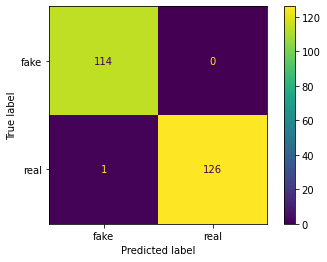

In [532]:
# Confusion matrix

from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report)

# Evaluate the model using a confusion matrix

cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=['fake','real'])
cmd.plot()

plt.show()

In [534]:
# Print the Classification Report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       114
           1       1.00      0.99      1.00       127

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241

